# Жим штанги лёжа - предсказание рекорда. Описание проекта.

Сылка на Kaggle: https://www.kaggle.com/datasets/kukuroo3/powerlifting-benchpress-weight-predict

В данном датасете представлена информация о спортсменах - пауэрлифтерах: их данные и рекорды в трёх основных упражнениях (присед, становая тяга, жим лёжа). Рекорд в жиме лёжа в данном проекте является целевым признаком, для предсказания его на основе остальных признаков будет решаться задача регрессии. В качестве метрики будем использовать MAPE.

# Загрузка и обработка данных.

Загружаем необходимые нам библиотеки.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go

!pip install phik
from phik import report
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

!pip install catboost
from catboost import CatBoostRegressor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 7.6 MB/s eta 0:00:00


Фиксируем переменную для random state.

In [ ]:
RNDM_STATE = 42

Загружаем данные.

In [ ]:
X_train = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/Datasets/Powerlifting/X_train.csv',
    sep=',')
y_train = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/Datasets/Powerlifting/y_train.csv',
    sep=',')
X_test = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/Datasets/Powerlifting/X_test.csv',
    sep=',')
y_test = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/Datasets/Powerlifting/y_test.csv',
    sep=',')

Все данные сразу разбиты на выборки, но нам это неудобно, позже разобьём сами.


Сначала исследуем таблицы, для этого напишем функцию, затем входящие признаки выборок с таргетом, а после-всё объединим в одну таблицу.


In [ ]:
def df_info(df):
    print(df.info())
    print('')
    display(df.head(10))
    print('')
    display(df.describe())
    print('')
    print(f'Количество явных дубликатов в датафрейме: {df.duplicated().sum()}.')
    print('')
    print(
        f'Количество неявных дубликатов в датафрейме: {df.duplicated(subset=["playerId"], keep=False).sum()}.'
    )
    print('')
    print('Процент пропусков по столбцам:')
    display(
        pd.DataFrame(round(df.isna().mean() * 100, 2)).style.background_gradient(
            'coolwarm'
        )
    )

In [ ]:
df_info(X_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18900 entries, 0 to 18899
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   playerId        18900 non-null  float64
 1   Name            18900 non-null  object 
 2   Sex             18900 non-null  object 
 3   Equipment       18900 non-null  object 
 4   Age             18725 non-null  float64
 5   BodyweightKg    18900 non-null  float64
 6   BestSquatKg     18900 non-null  object 
 7   BestDeadliftKg  18900 non-null  float64
dtypes: float64(4), object(4)
memory usage: 1.2+ MB
None



,playerId,Name,Sex,Equipment,Age,BodyweightKg,BestSquatKg,BestDeadliftKg
0,19391.0,Carlos Ceron,M,Raw,23.0,87.30,205.0,235.0
1,15978.0,Tito Herrera,M,Wraps,23.0,73.48,220.0,260.0
2,27209.0,Levi Lehman,M,Raw,26.0,112.40,142.5,220.0
3,27496.0,Stacy Hayford,F,Raw,35.0,59.42,95.0,102.5
4,20293.0,Brittany Hirt,F,Raw,26.5,61.40,105.0,127.5
5,25176.0,Zoran Jankovski,M,Wraps,23.0,113.50,260.0,285.0
6,128.0,Mitchell Hayes,M,Raw,22.5,90.55,162.5,200.0
7,28187.0,John Gibson,M,Raw,24.0,100.00,200.0,227.5
8,8022.0,Sakiko Ito,F,Single-ply,19.5,51.20,115.0,127.5
9,22487.0,Lorrie Bosen,F,Raw,54.0,65.25,72.5,115.0


,playerId,Age,BodyweightKg,BestDeadliftKg
count,18900.00000,18725.00000,18900.000000,18900.00000
mean,15039.49963,29.66470,85.425557,201.12277
std,8674.67268,11.55708,22.959720,62.17163
min,0.00000,7.00000,26.130000,18.10000
25%,7462.75000,21.50000,67.700000,149.85750
50%,15122.50000,26.50000,82.100000,204.12000
75%,22540.25000,35.00000,98.970000,247.50000
max,29998.00000,83.00000,201.000000,408.23000



Количество явных дубликатов в датафрейме: 0.

Количество неявных дубликатов в датафрейме: 0.

Процент пропусков по столбцам:


,0
playerId,0.000000
Name,0.000000
Sex,0.000000
Equipment,0.000000
Age,0.930000
BodyweightKg,0.000000
BestSquatKg,0.000000
BestDeadliftKg,0.000000


Пропуски в возрасте заполняем медианой.

In [ ]:
X_train['Age'].fillna(X_train['Age'].median(), inplace=True)

In [ ]:
df_info(y_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18900 entries, 0 to 18899
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   playerId     18900 non-null  float64
 1   BestBenchKg  18900 non-null  float64
dtypes: float64(2)
memory usage: 295.4 KB
None



,playerId,BestBenchKg
0,19391.0,125.0
1,15978.0,157.5
2,27209.0,145.0
3,27496.0,60.0
4,20293.0,60.0
5,25176.0,160.0
6,128.0,107.5
7,28187.0,180.0
8,8022.0,62.5
9,22487.0,55.0


,playerId,BestBenchKg
count,18900.00000,18900.000000
mean,15039.49963,116.963389
std,8674.67268,51.231651
min,0.00000,9.100000
25%,7462.75000,72.500000
50%,15122.50000,115.000000
75%,22540.25000,150.000000
max,29998.00000,425.000000



Количество явных дубликатов в датафрейме: 0.

Количество неявных дубликатов в датафрейме: 0.

Процент пропусков по столбцам:


,0
playerId,0.000000
BestBenchKg,0.000000


Объединяем.

In [ ]:
train_df = pd.merge(X_train, y_train, on='playerId')
train_df

,playerId,Name,Sex,Equipment,Age,BodyweightKg,BestSquatKg,BestDeadliftKg,BestBenchKg
0,19391.0,Carlos Ceron,M,Raw,23.0,87.30,205.0,235.00,125.00
1,15978.0,Tito Herrera,M,Wraps,23.0,73.48,220.0,260.00,157.50
2,27209.0,Levi Lehman,M,Raw,26.0,112.40,142.5,220.00,145.00
3,27496.0,Stacy Hayford,F,Raw,35.0,59.42,95.0,102.50,60.00
4,20293.0,Brittany Hirt,F,Raw,26.5,61.40,105.0,127.50,60.00
...,...,...,...,...,...,...,...,...,...
18895,29802.0,Rachael Podolak,F,Raw,20.0,65.70,92.5,135.00,55.00
18896,5390.0,Daniel Andersen,M,Raw,23.5,88.85,190.0,230.00,125.00
18897,860.0,Mark Brewer,M,Multi-ply,43.0,106.78,206.38,229.06,151.95
18898,15795.0,Michael Perkins,M,Raw,22.5,82.00,235.0,272.50,135.00


In [ ]:
df_info(X_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11100 entries, 0 to 11099
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   playerId        11100 non-null  float64
 1   Name            11100 non-null  object 
 2   Sex             11100 non-null  object 
 3   Equipment       11100 non-null  object 
 4   Age             10855 non-null  float64
 5   BodyweightKg    11100 non-null  float64
 6   BestSquatKg     11100 non-null  float64
 7   BestDeadliftKg  11100 non-null  float64
dtypes: float64(5), object(3)
memory usage: 693.9+ KB
None



,playerId,Name,Sex,Equipment,Age,BodyweightKg,BestSquatKg,BestDeadliftKg
0,2308.0,Peter Neeves,M,Wraps,30.0,89.81,179.17,192.78
1,22404.0,Josh Padilla,M,Raw,27.0,74.95,125.00,165.00
2,23397.0,Luke Dreier,M,Wraps,30.0,122.61,290.00,317.50
3,25058.0,Jacob New,M,Raw,20.0,88.00,187.50,240.00
4,2664.0,Jesse Burdick,M,Wraps,30.0,122.00,235.01,275.01
5,8511.0,Jake Minnis,M,Raw,25.0,67.00,185.00,190.00
6,5148.0,Michelle Paquette,F,Raw,30.0,58.80,102.50,147.50
7,7790.0,Laura Lay,F,Raw,32.0,62.40,80.00,105.00
8,11311.0,Jared O'Grady,M,Wraps,39.0,52.00,120.00,172.50
9,19043.0,Adrian Solana Guerrero,M,Single-ply,22.5,91.62,250.00,290.00


,playerId,Age,BodyweightKg,BestSquatKg,BestDeadliftKg
count,11100.000000,10855.000000,11100.000000,11100.000000,11100.000000
mean,14931.392523,29.703086,85.245934,179.352391,201.099868
std,8636.003197,11.609336,22.749439,69.410025,62.709112
min,3.000000,8.500000,24.100000,20.000000,25.000000
25%,7551.750000,21.500000,68.522500,124.730000,147.500000
50%,14823.500000,26.500000,82.100000,175.000000,204.120000
75%,22404.250000,35.000000,98.700000,222.500000,247.500000
max,29999.000000,89.500000,242.400000,532.970000,420.500000



Количество явных дубликатов в датафрейме: 0.

Количество неявных дубликатов в датафрейме: 0.

Процент пропусков по столбцам:


,0
playerId,0.000000
Name,0.000000
Sex,0.000000
Equipment,0.000000
Age,2.210000
BodyweightKg,0.000000
BestSquatKg,0.000000
BestDeadliftKg,0.000000


Снова заполняем пропуски в данных о возрасте медианным значением.

In [ ]:
X_test['Age'].fillna(X_test['Age'].median(), inplace=True)

In [ ]:
df_info(y_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11100 entries, 0 to 11099
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   playerId        11100 non-null  float64
 1   BestBenchKg     11100 non-null  float64
 2   Age             0 non-null      float64
 3   BodyweightKg    0 non-null      float64
 4   BestDeadliftKg  0 non-null      float64
dtypes: float64(5)
memory usage: 433.7 KB
None



,playerId,BestBenchKg,Age,BodyweightKg,BestDeadliftKg
0,2308.0,97.52,NaN,NaN,NaN
1,22404.0,75.00,NaN,NaN,NaN
2,23397.0,190.00,NaN,NaN,NaN
3,25058.0,117.50,NaN,NaN,NaN
4,2664.0,145.01,NaN,NaN,NaN
5,8511.0,110.00,NaN,NaN,NaN
6,5148.0,60.00,NaN,NaN,NaN
7,7790.0,52.50,NaN,NaN,NaN
8,11311.0,95.00,NaN,NaN,NaN
9,19043.0,162.50,NaN,NaN,NaN


,playerId,BestBenchKg,Age,BodyweightKg,BestDeadliftKg
count,11100.000000,11100.000000,0.0,0.0,0.0
mean,14931.392523,115.731901,NaN,NaN,NaN
std,8636.003197,54.209846,NaN,NaN,NaN
min,3.000000,-280.000000,NaN,NaN,NaN
25%,7551.750000,70.000000,NaN,NaN,NaN
50%,14823.500000,115.000000,NaN,NaN,NaN
75%,22404.250000,150.000000,NaN,NaN,NaN
max,29999.000000,377.500000,NaN,NaN,NaN



Количество явных дубликатов в датафрейме: 0.

Количество неявных дубликатов в датафрейме: 0.

Процент пропусков по столбцам:


,0
playerId,0.000000
BestBenchKg,0.000000
Age,100.000000
BodyweightKg,100.000000
BestDeadliftKg,100.000000


Выкидываем пустые столбцы.

In [ ]:
y_test = y_test.drop(['Age', 'BodyweightKg', 'BestDeadliftKg'], axis=1)

Отрицательные значения заменим на значения по модулю.

In [ ]:
y_test['BestBenchKg'] = y_test['BestBenchKg'].abs()

Снова объединяем.

In [ ]:
test_df = pd.merge(X_test, y_test, on='playerId')
test_df

,playerId,Name,Sex,Equipment,Age,BodyweightKg,BestSquatKg,BestDeadliftKg,BestBenchKg
0,2308.0,Peter Neeves,M,Wraps,30.0,89.81,179.17,192.78,97.52
1,22404.0,Josh Padilla,M,Raw,27.0,74.95,125.00,165.00,75.00
2,23397.0,Luke Dreier,M,Wraps,30.0,122.61,290.00,317.50,190.00
3,25058.0,Jacob New,M,Raw,20.0,88.00,187.50,240.00,117.50
4,2664.0,Jesse Burdick,M,Wraps,30.0,122.00,235.01,275.01,145.01
...,...,...,...,...,...,...,...,...,...
11095,3104.0,Dimitrios Rallis,M,Wraps,28.0,98.20,270.00,315.00,160.00
11096,10239.0,Amber Skewes,F,Raw,36.0,58.80,92.50,137.50,57.50
11097,29044.0,Brandon Mose,M,Raw,22.5,82.62,250.00,311.00,175.00
11098,29947.0,Missy Lavoie,F,Wraps,28.0,74.30,105.00,152.50,70.00


Объединяем всё в единую таблицу.

In [ ]:
df = pd.concat([train_df, test_df], ignore_index=True)

Смотрим данные о ней.

In [ ]:
df_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   playerId        30000 non-null  float64
 1   Name            30000 non-null  object 
 2   Sex             30000 non-null  object 
 3   Equipment       30000 non-null  object 
 4   Age             30000 non-null  float64
 5   BodyweightKg    30000 non-null  float64
 6   BestSquatKg     30000 non-null  object 
 7   BestDeadliftKg  30000 non-null  float64
 8   BestBenchKg     30000 non-null  float64
dtypes: float64(5), object(4)
memory usage: 2.1+ MB
None



,playerId,Name,Sex,Equipment,Age,BodyweightKg,BestSquatKg,BestDeadliftKg,BestBenchKg
0,19391.0,Carlos Ceron,M,Raw,23.0,87.30,205.0,235.0,125.0
1,15978.0,Tito Herrera,M,Wraps,23.0,73.48,220.0,260.0,157.5
2,27209.0,Levi Lehman,M,Raw,26.0,112.40,142.5,220.0,145.0
3,27496.0,Stacy Hayford,F,Raw,35.0,59.42,95.0,102.5,60.0
4,20293.0,Brittany Hirt,F,Raw,26.5,61.40,105.0,127.5,60.0
5,25176.0,Zoran Jankovski,M,Wraps,23.0,113.50,260.0,285.0,160.0
6,128.0,Mitchell Hayes,M,Raw,22.5,90.55,162.5,200.0,107.5
7,28187.0,John Gibson,M,Raw,24.0,100.00,200.0,227.5,180.0
8,8022.0,Sakiko Ito,F,Single-ply,19.5,51.20,115.0,127.5,62.5
9,22487.0,Lorrie Bosen,F,Raw,54.0,65.25,72.5,115.0,55.0


,playerId,Age,BodyweightKg,BestDeadliftKg,BestBenchKg
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,14999.500000,29.634283,85.359097,201.114296,116.957666
std,8660.398374,11.500847,22.881926,62.369995,51.342817
min,0.000000,7.000000,24.100000,18.100000,9.100000
25%,7499.750000,21.500000,68.050000,147.500000,72.500000
50%,14999.500000,26.500000,82.100000,204.120000,115.000000
75%,22499.250000,34.500000,98.880000,247.500000,150.000000
max,29999.000000,89.500000,242.400000,420.500000,425.000000



Количество явных дубликатов в датафрейме: 0.

Количество неявных дубликатов в датафрейме: 0.

Процент пропусков по столбцам:


,0
playerId,0.000000
Name,0.000000
Sex,0.000000
Equipment,0.000000
Age,0.000000
BodyweightKg,0.000000
BestSquatKg,0.000000
BestDeadliftKg,0.000000
BestBenchKg,0.000000


Итого в собранном датасете имеем следующие признаки:
- playerId - идентификационный номер спортсмена;
- Name - имя спортсмена;
- Sex - пол спортсмена;
- Equipment - тип используемой экпипировки;
- Age - возраст спортсмена;
- BodyweightKg - вес спортсмена;
- BestSquatKg - рекорд в приседе со штангой, кг;
- BestDeadliftKg - рекорд в становой тяге, кг;
- BestBenchKg - рекорд в жиме штанги лёжа, кг (целевой признак).

Меняем тип данных у столбца с рекордами спортсменов в приседе на float.

In [ ]:
df['BestSquatKg'] = pd.to_numeric(df['BestSquatKg'], errors='coerce')
df.dropna(subset=['BestSquatKg'], inplace=True)
df['BestSquatKg'] = df['BestSquatKg'].astype(float)
df['BestSquatKg']  = df['BestSquatKg'].abs()

Также сразу даляем бессмысленные для нашей задачи столбцы с именем спортсмена и идентификационным номером.

In [ ]:
df = df.drop(['Name', 'playerId'], axis=1)

## Выводы по разделу.
- Загружены все необходимые для работы библиотеки и данные.
- Данные уже разделены на выборки, но нам удобнее объединить их вединый датасет, а после уже разбить самостоятельно.
- Пропуски в возрасте спортсменов заполнены медианным значением.
- Неверный тип данных столбца BestSquatKg заменён.
- Удалены бесполезные для дальнейшего машинного обучения данные об именах спортсменов и их идентификационных номерах в таблице.

# Построение графиков.

Посмотрим распределение данны численных переменных.

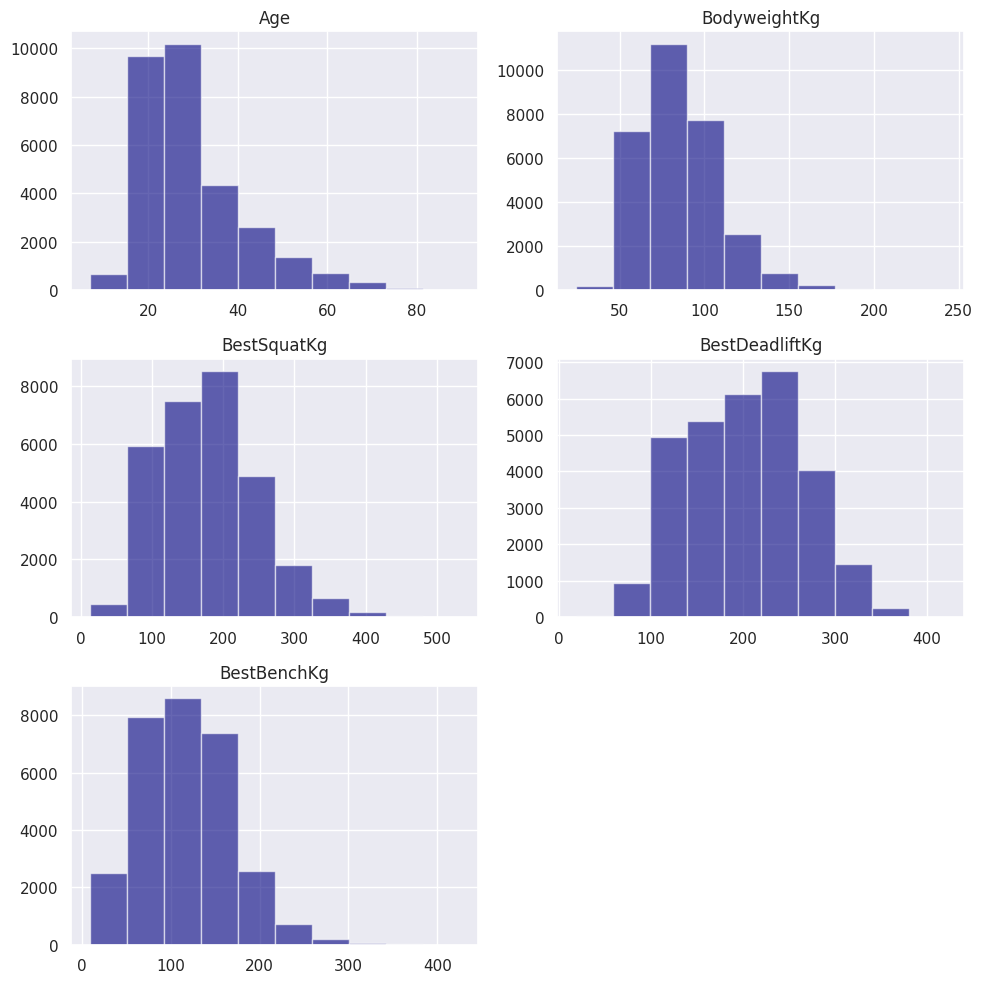

In [ ]:
df.hist(figsize=(10, 10), color='navy', alpha = 0.6)
plt.tight_layout()
plt.show()

Смотрим в каких процентах представлены мужчины и женщины в наших данных.

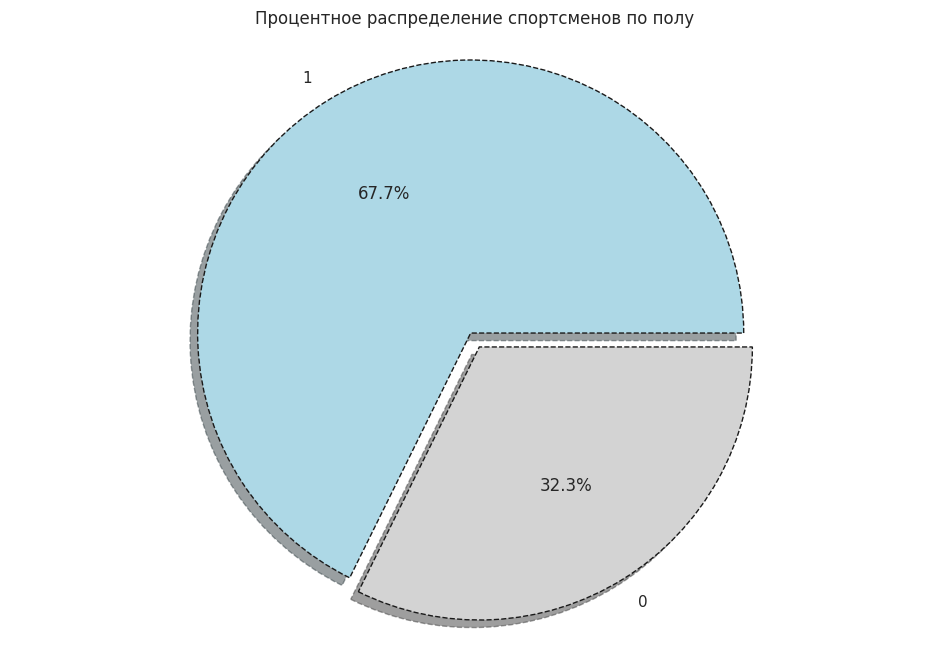

In [ ]:
counts = df['Sex'].value_counts()

explode = [0.05, 0.01] + [0] * (len(counts) - 3)
plt.figure(figsize=(12, 8))
plt.pie(
    counts.values,
    labels=counts.index,
    autopct='%1.1f%%',
    shadow=True,
    explode=explode,
    colors=['lightblue', 'lightgrey'] + ['C0'] * (len(counts) - 3),
    wedgeprops={'lw': 1, 'ls': '--', 'edgecolor': 'k'},
)
plt.axis('equal')
plt.title('Процентное распределение спортсменов по полу')
plt.show()

Смотрим медианные значения рекорда в жиме штанги лёжа для мужчин и женщин.

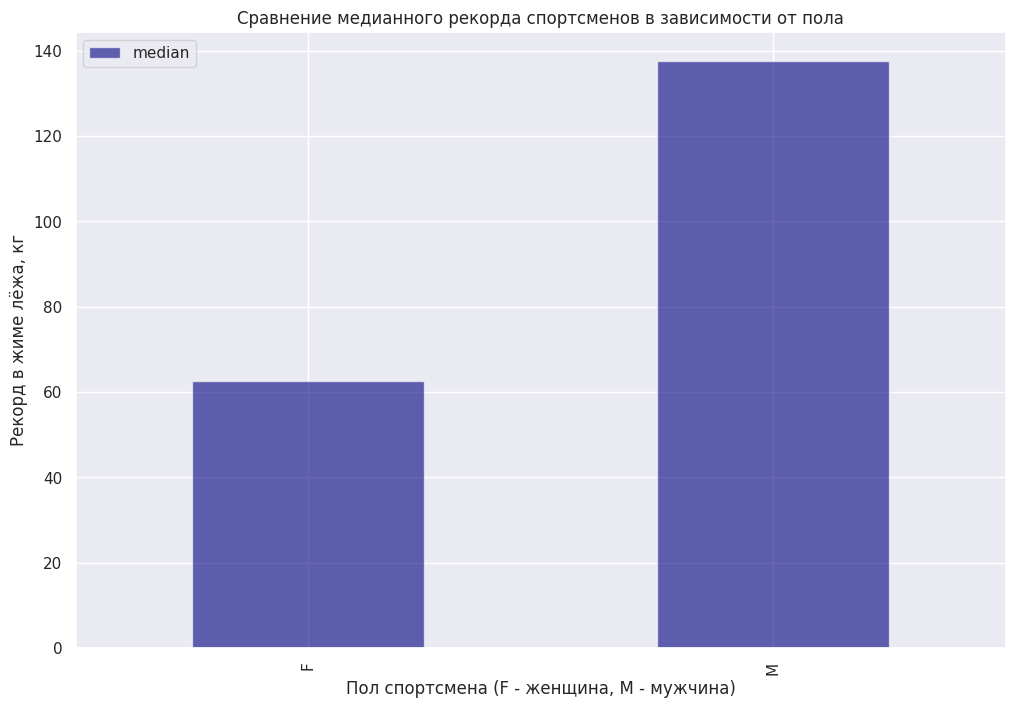

In [ ]:
sex_best_bench_median = df.groupby('Sex')['BestBenchKg'].agg(['median']).sort_values(by='median')

sns.set(rc={'figure.figsize':(12, 8)})
sex_best_bench_median.plot(kind='bar', color='navy', alpha=0.6)

plt.xlabel('Пол спортсмена (F - женщина, M - мужчина)')
plt.ylabel('Рекорд в жиме штанги лёжа, кг')
plt.title('Сравнение медианного рекорда спортсменов в зависимости от пола')

plt.show()

Смотрим, чему равны медианные значения рекорда в жиме лёжа в зависимости от применяемой экипировки.

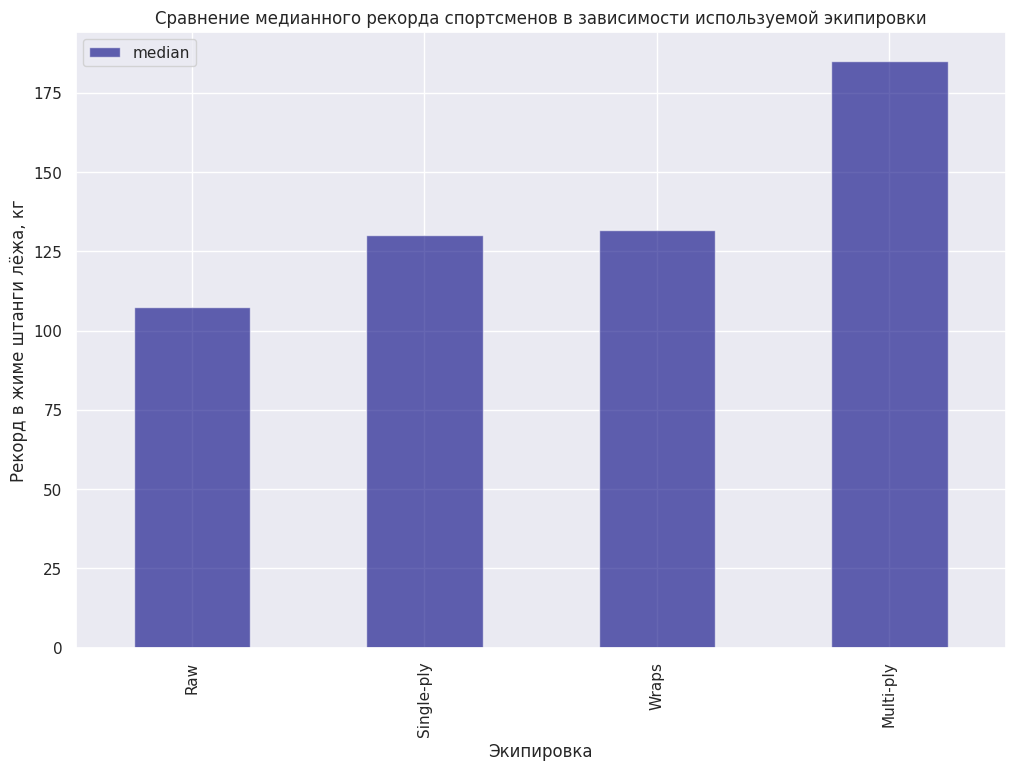

In [ ]:
equipment_best_bench_median = (
    df.groupby('Equipment')['BestBenchKg'].agg(['median']).sort_values(by='median')
)

sns.set(rc={'figure.figsize': (12, 8)})
equipment_best_bench_median.plot(kind='bar', color='navy', alpha=0.6)
plt.xlabel('Экипировка')
plt.ylabel('Рекорд в жиме штанги лёжа, кг')
plt.title(
    'Сравнение медианного рекорда спортсменов в зависимости используемой экипировки'
)

plt.show()

Смотрим, как возраст спортсмена и его собственный вес влияют на рекорд в жиме лёжа.

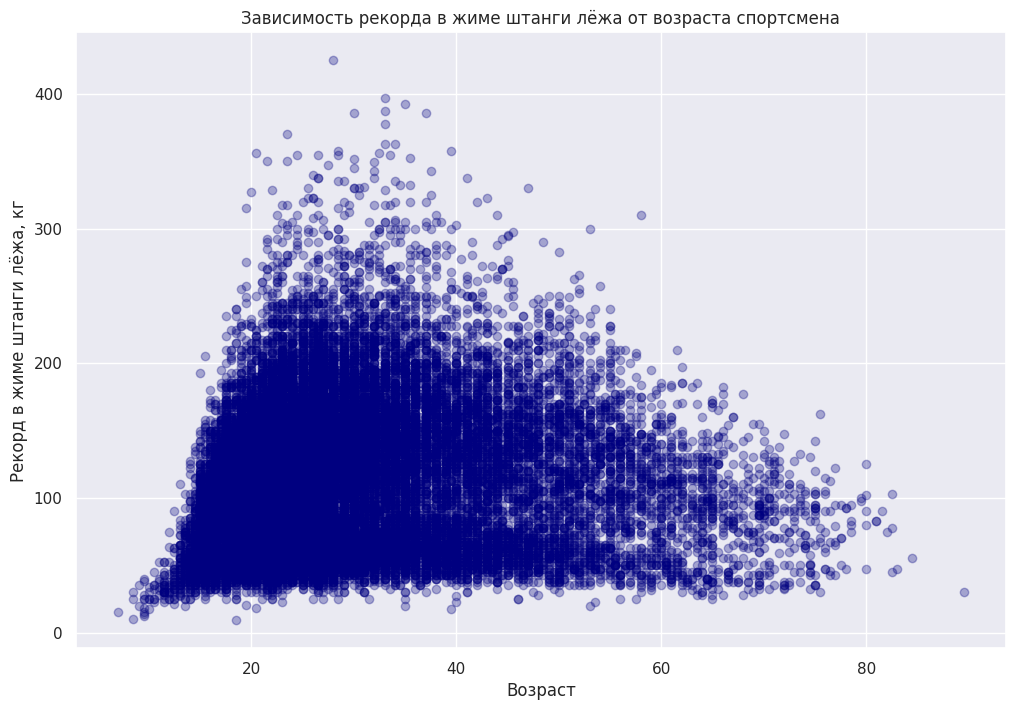

In [ ]:
sns.set(rc={'figure.figsize':(12, 8)})
plt.scatter(df['Age'], df['BestBenchKg'], color='navy', alpha = 0.3)

plt.xlabel('Возраст')
plt.ylabel('Рекорд в жиме штанги лёжа, кг')
plt.title('Зависимость рекорда в жиме штанги лёжа от возраста спортсмена')

plt.show()

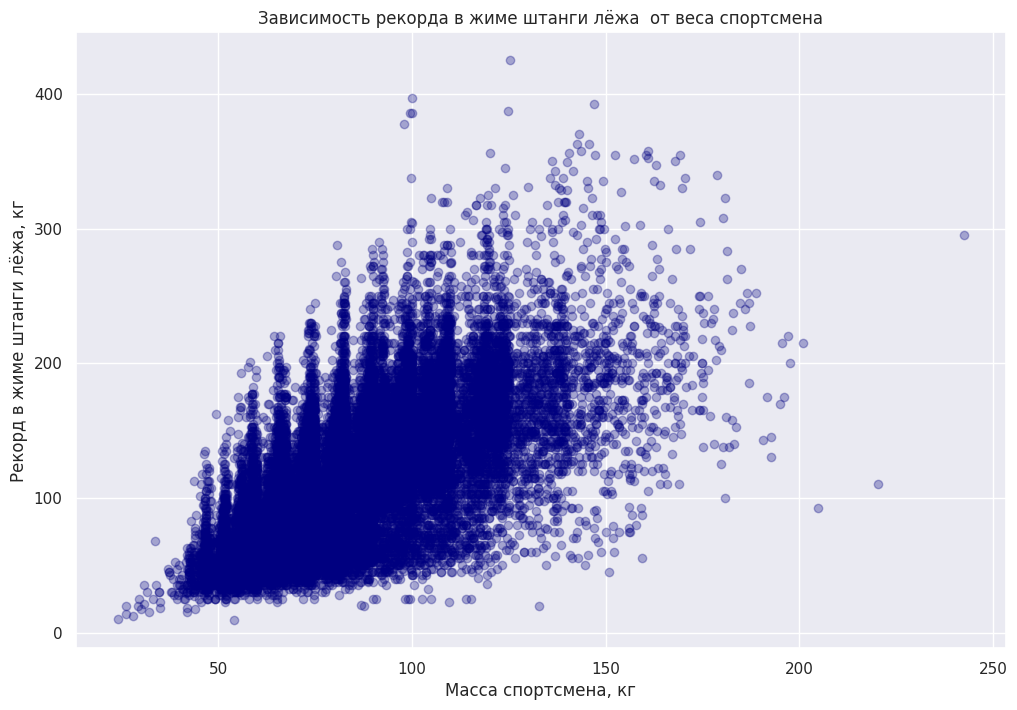

In [ ]:
sns.set(rc={'figure.figsize':(12, 8)})
plt.scatter(df['BodyweightKg'], df['BestBenchKg'], color='navy', alpha = 0.3)

plt.xlabel('Масса спортсмена, кг')
plt.ylabel('Рекорд в жиме штанги лёжа, кг')
plt.title('Зависимость рекорда в жиме штанги лёжа  от веса спортсмена')

plt.show()

И, наконец, смотрим, как рекорды в приседе со штангой и становой тяге влияют на лучший показатель в жиме лёжа.

In [ ]:
fig = go.Figure(data=[go.Scatter3d(
    x=df['BestSquatKg'],
    y=df['BestDeadliftKg'],
    z=df['BestBenchKg'],
    mode='markers',
    marker=dict(
        color='navy',
        opacity=0.1
    )
)])

fig.update_layout(scene=dict(
    xaxis_title='Рекорд в приседе со штангой, кг',
    yaxis_title='Рекорд в становой тяге, кг',
    zaxis_title='Рекорд в жиме штанги лёжа, кг'
))

fig.show()

## Выводы по разделу.
- Больше всего в рассматриваемых данных представлено спортсменов от 20 до 30 лет и весовой категории до 100 кг.
- Мужчин в таблице в 2 раза больше, чем женщин.
- Медианное значение по таблице рекорда в жиме лёжа у женщин 62.5 кг, у мужчин 137.5 кг.
- По медианному значению (185 кг) наилучший показатель в жиме штанги лёжа получается при экипировке класс multiply.
- Также, исходя из графиков, можно предположить, что эти рекорды ставят в основном люди от 20 до 40 лет с собственной массой от 100 до 150 кг. Кроме того наилучших результатов в жиме лёжа предположительно в основном добавиются спортсмены с наилучшими показателями в приседе и становой тяги.

# Корреляции.

Смотрим корреляции признаков с помощью библиотеки phik.

In [ ]:
phik_overview = df.phik_matrix()

interval columns not set, guessing: ['Age', 'BodyweightKg', 'BestSquatKg', 'BestDeadliftKg', 'BestBenchKg']


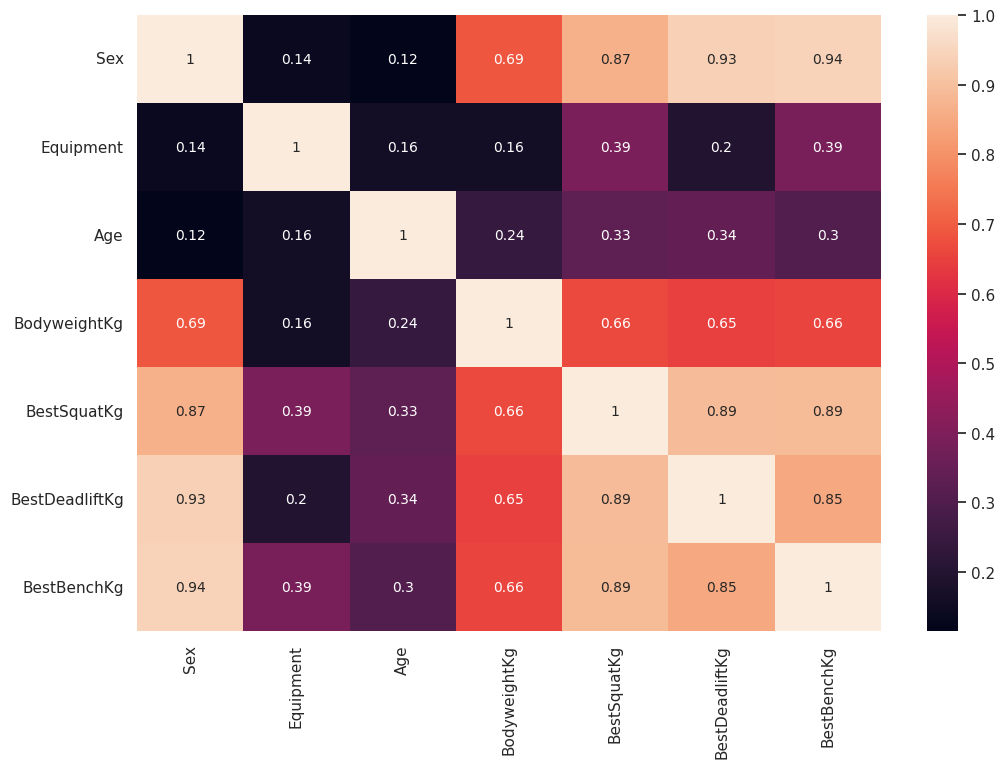

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(phik_overview, annot=True, annot_kws={'fontsize': 10})
plt.show()

Вызываем список корреляций с целевым признаком.

In [ ]:
phik_overview['BestBenchKg'].sort_values(ascending = False)

BestBenchKg       1.000000
Sex               0.942693
BestSquatKg       0.888615
BestDeadliftKg    0.848117
BodyweightKg      0.655700
Equipment         0.386041
Age               0.302928
Name: BestBenchKg, dtype: float64

## Выводы по разделу.
Исходя из значений коэффициента, все оставшиеся фичи ощутимо влияют на таргет.

# Обучение моделей.

Переводим запись пола спортсменов в бинарный вид.

In [ ]:
df['Sex'] = df['Sex'].map({'M': 1, 'F': 0})

Создаём список с категориальными и числовыми признаками.

In [ ]:
cat_features_names = ['Equipment']
num_features_names = ['Sex', 'BestSquatKg', 'BestDeadliftKg', 'BodyweightKg', 'Age']

Разбиваем данные сначала на тренировочную и валидационную + тестовую выборки.

In [ ]:
df_train, df_valid_test = train_test_split(df, test_size = 0.4, random_state = RNDM_STATE)

In [ ]:
features_train = df_train.drop(['BestBenchKg'], axis = 1)
target_train = df_train['BestBenchKg']
features_valid_test = df_valid_test.drop(['BestBenchKg'], axis = 1)
target_valid_test = df_valid_test['BestBenchKg']

Теперь разделяем валидационную и тестовую.

In [ ]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size = 0.5, random_state = RNDM_STATE)

Кодируем категориальный признак, отвечающий за используемую спортсменами экипировку, с помощью OHE.

In [ ]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore')

features_train_encoding = features_train.copy()
features_test_encoding = features_test.copy()
features_valid_encoding = features_valid.copy()

encoder_ohe.fit(features_train_encoding[cat_features_names])
new_columns = encoder_ohe.get_feature_names_out(cat_features_names)
train_ohe = pd.DataFrame(
    encoder_ohe.transform(features_train_encoding[cat_features_names]).toarray(),
    columns=new_columns,
    index=features_train.index,
)
features_train_ohe = train_ohe.join(features_train_encoding[num_features_names])

valid_ohe = pd.DataFrame(
    encoder_ohe.transform(features_valid_encoding[cat_features_names]).toarray(),
    columns=new_columns,
    index=features_valid.index,
)
features_valid_ohe = valid_ohe.join(features_valid_encoding[num_features_names])


test_ohe = pd.DataFrame(
    encoder_ohe.transform(features_test_encoding[cat_features_names]).toarray(),
    columns=new_columns,
    index=features_test_encoding.index,
)
features_test_ohe = test_ohe.join(features_test_encoding[num_features_names])

Выделяем небинарные числовые признаки и стандартизируем их.

In [ ]:
not_bin_num_features_names = ['BestSquatKg', 'BestDeadliftKg', 'BodyweightKg', 'Age' ]

In [ ]:
scaler = StandardScaler()

features_train_ohe_scaled = features_train_ohe.copy()
features_valid_ohe_scaled = features_valid_ohe.copy()
features_test_ohe_scaled = features_test_ohe.copy()

scaler.fit(features_train_ohe[not_bin_num_features_names])

features_train_ohe_scaled[not_bin_num_features_names] = scaler.transform(
    features_train_ohe_scaled[not_bin_num_features_names]
)
features_valid_ohe_scaled[not_bin_num_features_names] = scaler.transform(
    features_valid_ohe_scaled[not_bin_num_features_names]
)
features_test_ohe_scaled[not_bin_num_features_names] = scaler.transform(
    features_test_ohe_scaled[not_bin_num_features_names]
)

Чтобы понять, от чего отталкиваться, посмотрим какую величину метрики MAPE выдаст у нас dummy-модель, просто предсказывающая для целевого признака медианное значение.

In [ ]:
dummy = DummyRegressor(strategy='median')

dummy.fit(features_train_ohe_scaled, target_train)
predictions_dummy = dummy.predict(features_valid_ohe_scaled)
mape_dummy = np.mean(np.abs((target_valid - predictions_dummy) / target_valid)) * 100

print(f'Значение MAPE для dummy-модели на валидационной выборке: {mape_dummy}')

Значение MAPE для dummy-модели на валидационной выборке: 46.88997599407106


Теперь посмотрим, какую величину ошибки выдаст в аналогичной ситуации линейная регрессия.

In [ ]:
lr = LinearRegression()

lr.fit(features_train_ohe_scaled, target_train)
predictions_lr = lr.predict(features_valid_ohe_scaled)
mape_lr = np.mean(np.abs((target_valid - predictions_lr) / target_valid)) * 100

print(f'Значение MAPE для модели линейной регрессии на валидационной выборке: {mape_lr}')

Значение MAPE для модели линейной регрессии на валидационной выборке: 12.748832591674375


Уже значительно лучше, но теперь протестируем модель градиентного бустинга в лице CatBoost.

In [ ]:
model_cb = CatBoostRegressor(
    learning_rate=0.01,
    eval_metric="MAPE",
    cat_features=cat_features_names,
    random_seed=RNDM_STATE,
    depth=9,
)
model_cb.fit(features_train, target_train, eval_set=(features_valid, target_valid))


0:	learn: 0.4774826	test: 0.4720450	best: 0.4720450 (0)	total: 107ms	remaining: 1m 47s
1:	learn: 0.4733518	test: 0.4679702	best: 0.4679702 (1)	total: 156ms	remaining: 1m 18s
2:	learn: 0.4693101	test: 0.4639908	best: 0.4639908 (2)	total: 192ms	remaining: 1m 3s
3:	learn: 0.4652396	test: 0.4599999	best: 0.4599999 (3)	total: 232ms	remaining: 57.7s
4:	learn: 0.4611896	test: 0.4560339	best: 0.4560339 (4)	total: 287ms	remaining: 57.2s
5:	learn: 0.4573186	test: 0.4522454	best: 0.4522454 (5)	total: 343ms	remaining: 56.8s
6:	learn: 0.4534780	test: 0.4484664	best: 0.4484664 (6)	total: 381ms	remaining: 54s
7:	learn: 0.4496007	test: 0.4446507	best: 0.4446507 (7)	total: 432ms	remaining: 53.6s
8:	learn: 0.4457632	test: 0.4408684	best: 0.4408684 (8)	total: 489ms	remaining: 53.9s
9:	learn: 0.4419435	test: 0.4371152	best: 0.4371152 (9)	total: 556ms	remaining: 55s
10:	learn: 0.4382742	test: 0.4335082	best: 0.4335082 (10)	total: 602ms	remaining: 54.2s
11:	learn: 0.4345641	test: 0.4298669	best: 0.4298669 (

Отлично, с помощью этой модели мы смогли снизить ошибку до 11.86%. Запустим эту же модель теперь с тестовыми данными.

In [ ]:
predictions = model_cb.predict(features_test)

In [ ]:
mape_cb_test = mean_absolute_percentage_error(target_test, predictions)
print(f'Значение MAPE на тестовой выборке: {mape_cb_test * 100} %')

Значение MAPE на тестовой выборке: 11.576988290271888 %


Значение MAPE ещё немного снизилось.

Напоследок посмотрим значимость для модели использованных параметров.

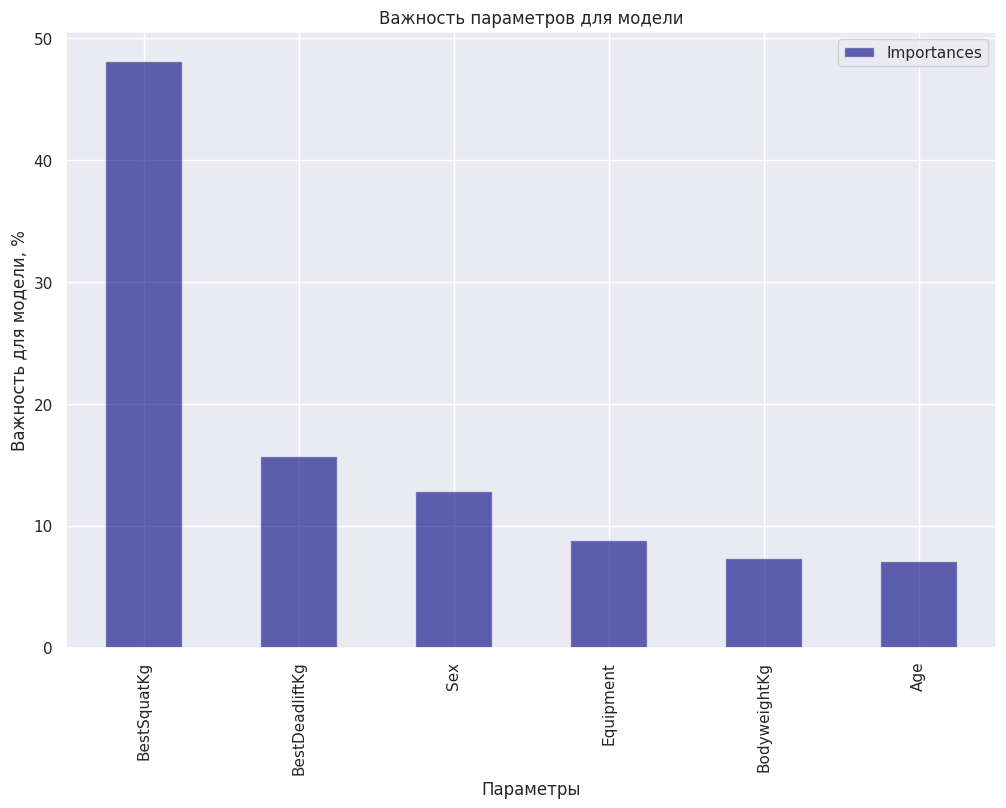

In [ ]:
feature_importance = model_cb.get_feature_importance(prettified=True)

sns.set(rc={'figure.figsize': (12, 8)})
feature_importance.plot(
    x='Feature Id', y='Importances', kind='bar', color='navy', alpha=0.6
)
plt.xlabel('Параметры')
plt.ylabel('Важность для модели, %')
plt.title('Важность параметров для модели')

plt.show()

## Выводы по разделу.
- Данные разбиты на тренировочную, валидационную и тестовую выборки.
- Категориальный параметр закодирован с помощью OHE.
- Числовые параметры подвергнуты стандартизации.
- На тренировочной выборки обучены и дали предсказание на валидационной медианная dummy-модель, линейная регрессия и CatBoost. Значение метрики MAPE оказалось ниже всего у последней модели (11.86 %).
- CatBoost дал предсказание на тестовых данных, величина MAPE на них 11.58 %.
- Наиболее важным для модели был параметр, отвечающий за рекорд спортсмена в приседе со штангой, наименее важным - возраст спортсмена.

# Общие выводы по проекту.
Как видно из результатов проекта, вопрос прогнозирования спортивных результатов на основе информации о спортсмене вполне неплохо может быть решён с помощью машинного обучения. Величина метрики MAPE 11.58 % без особых проблем была достигнута путём применения модели CatBoost.